# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import ipyvolume as ipv
import pathlib

import sys
sys.path.append("..") 
from cryoem.projections import RotationMatrix

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13385932844432669163
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15331733082959651427
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14040377509255478425
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16460040458243740973
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4774940389055056533
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memo

## Read data 

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
num_projections = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{num_projections}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

X, y = data['Projections'], data['Angles']
print(f"{X.shape[0]} projections of images with dimension {X.shape[1:]} pixels")
print(f"{y.shape[0]} sets of {y.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
# plot coverage
all_vectors = RotationMatrix(y)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

## Distances


#### Angle Distance

In [5]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [6]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

#### Projection Distance [basic: Euclidean]

In [7]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

In [8]:
assert tf.reduce_mean(d_p(X[0:3], X[0:3])) < 1e-7

---

## kNN of the Projections

In [9]:
k = 5

In [10]:
def get_knn_output(k):
    start_time = time()

    _X = np.reshape(X, (X.shape[0], -1))
    
    name = projections_filename.split('/')[-1]
    if not os.path.exists(f'data/knn{k}_{name}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(_X)
        distances_p, indices_p = nbrs.kneighbors(_X)
        A_p = nbrs.kneighbors_graph(_X).toarray()

        try:
            np.save(f'data/knn{k}_{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
            np.save(f'data/knn{k}_{name}_distances', distances_p)     # Array representing the lengths to points
            np.save(f'data/knn{k}_{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
        except:
            pass
        print(f"--- {time() - start_time} seconds ---")
    
    else:
        indices_p     = np.load(f'data/knn{k}_{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/knn{k}_{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/knn{k}_{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
    return indices_p, distances_p, A_p 

In [11]:
# --- 23594.572999954224 seconds ---
indices_p, distances_p, A_p = get_knn_output(k=k)

In [12]:
np.max(distances_p)

63.95002548806251

---

# 1. Metric Learning

## Prepare for training

In [13]:
def sample_pairs(projections, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        idx2 = list(np.random.choice(projections, size=num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.choice(projections, size=num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, indices, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=indices, num_pairs=num_pairs, style="random", k=k)
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)

In [15]:
EPOCHS = 100
BATCH_SIZE = 256
NUM_PROJECTIONS = 5000
NUM_PAIRS = 50000
LR = 0.001
CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

In [16]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [17]:
X[train_idx].shape

(2512, 116, 116)

In [18]:
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=50000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=10000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=10000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

In [19]:
input_shape = val_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

Input images shape (116, 116, 1)


In [20]:
tr_pairs.shape

(50000, 2, 116, 116, 1)

In [21]:
te_pairs[:, 0].shape

(10000, 116, 116, 1)

In [22]:
te_y.shape

TensorShape([10000])

### Train the model

In [23]:

# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)


# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])



model = Model([input_a, input_b], distance)


# train
#optimizer = RMSprop()
optimizer = Adam(learning_rate=LR)

model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])

model.summary()


# Create a callback that saves the model's weights
backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                              save_weights_only=True,
                              verbose=1)

history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y),
                  callbacks=[backup_callback])

model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
model.save(model_filename) 
print(f"Model saved to: {model_filename}")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

Epoch 25/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0485 - mae: 0.1767
Epoch 00025: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0485 - mae: 0.1767 - val_loss: 0.0786 - val_mae: 0.2166
Epoch 26/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0468 - mae: 0.1730
Epoch 00026: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0468 - mae: 0.1731 - val_loss: 0.0715 - val_mae: 0.2136
Epoch 27/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0467 - mae: 0.1729
Epoch 00027: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0467 - mae: 0.1729 - val_loss: 0.0732 - val_mae: 0.2155
Epoch 28/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0466 - mae: 0.1727
Epoch 00028: saving model to training/20191217_234508
50000/50000 

Epoch 55/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0408 - mae: 0.1606
Epoch 00055: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0408 - mae: 0.1606 - val_loss: 0.0701 - val_mae: 0.2109
Epoch 56/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0416 - mae: 0.1616
Epoch 00056: saving model to training/20191217_234508
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0416 - mae: 0.1616 - val_loss: 0.0714 - val_mae: 0.2094
Epoch 57/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0410 - mae: 0.1607
Epoch 00057: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0410 - mae: 0.1607 - val_loss: 0.0775 - val_mae: 0.2127
Epoch 58/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0403 - mae: 0.1596
Epoch 00058: saving model to training/20191217_234508
50000/50000 

Epoch 85/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1554
Epoch 00085: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0384 - mae: 0.1554 - val_loss: 0.0720 - val_mae: 0.2082
Epoch 86/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1555
Epoch 00086: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0384 - mae: 0.1555 - val_loss: 0.0698 - val_mae: 0.2067
Epoch 87/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0386 - mae: 0.1558
Epoch 00087: saving model to training/20191217_234508
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0387 - mae: 0.1558 - val_loss: 0.0762 - val_mae: 0.2121
Epoch 88/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1552
Epoch 00088: saving model to training/20191217_234508
50000/50000 

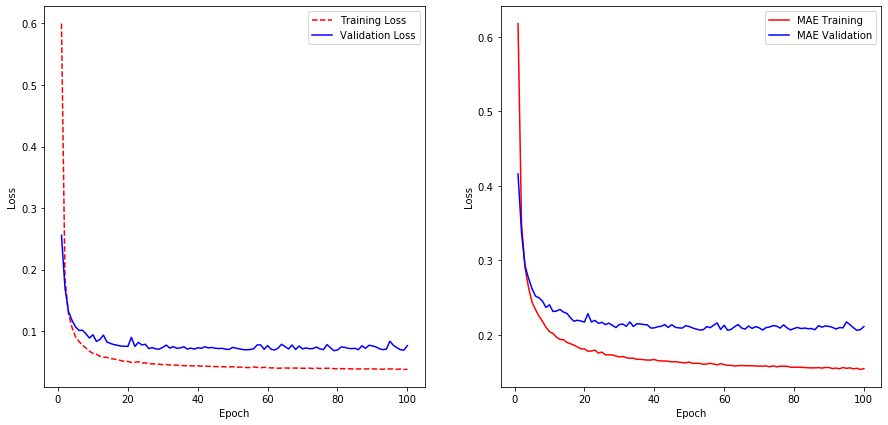

In [24]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']
maes = history.history['mae']
val_maes = history.history['val_mae']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, maes, 'r-', label='MAE Training')
ax2.plot(epoch_count, val_maes, 'b-', label='MAE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [23]:
model_filename = "training/20191218_023743.h5"

In [24]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [25]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [26]:
def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 0.43822476267814636
true:      0.25913941860198975
mse:       0.0320715606212616
mae:       0.17908534407615662


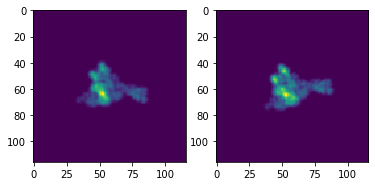

In [27]:
plot_train_results(1)

--- Validation Set ---
predicted: 1.4845402240753174
true:      1.6766462326049805
mse:       0.0369047187268734
mae:       0.19210600852966309


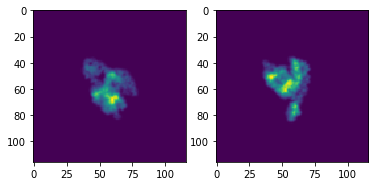

In [28]:
plot_validation_results(0)

---

## dP/dQ plot

### dP/dQ on Training

In [29]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)

In [33]:
# Creating the dataframe for SNS plot
data = {"d_Q" : tr_y.numpy(),
        "d_P" : y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
data = {"d_Q" : val_y.numpy(),
        "d_P" : y_val_pred.T[0]}
df2 = pd.DataFrame(data=data)

/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


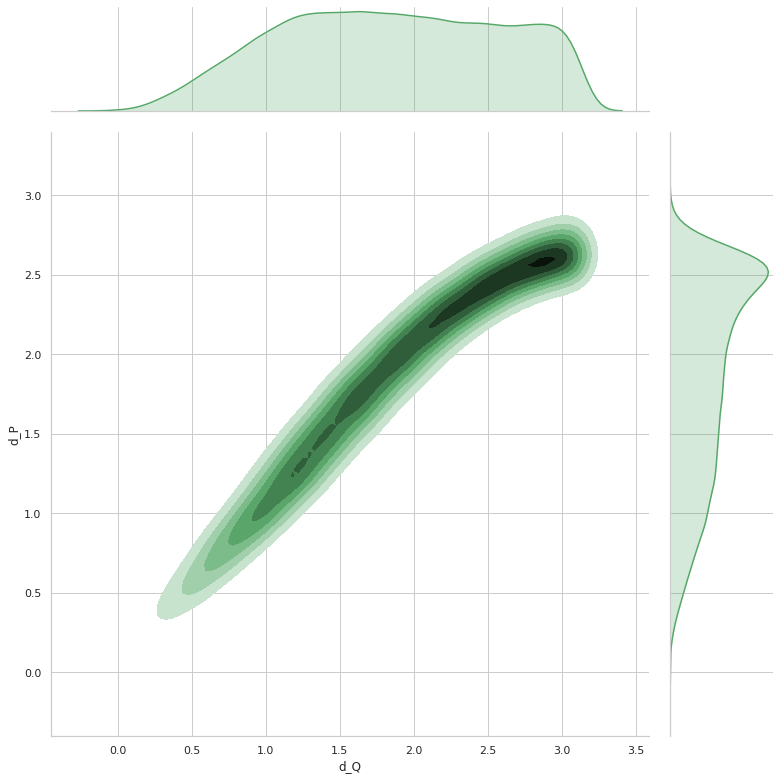

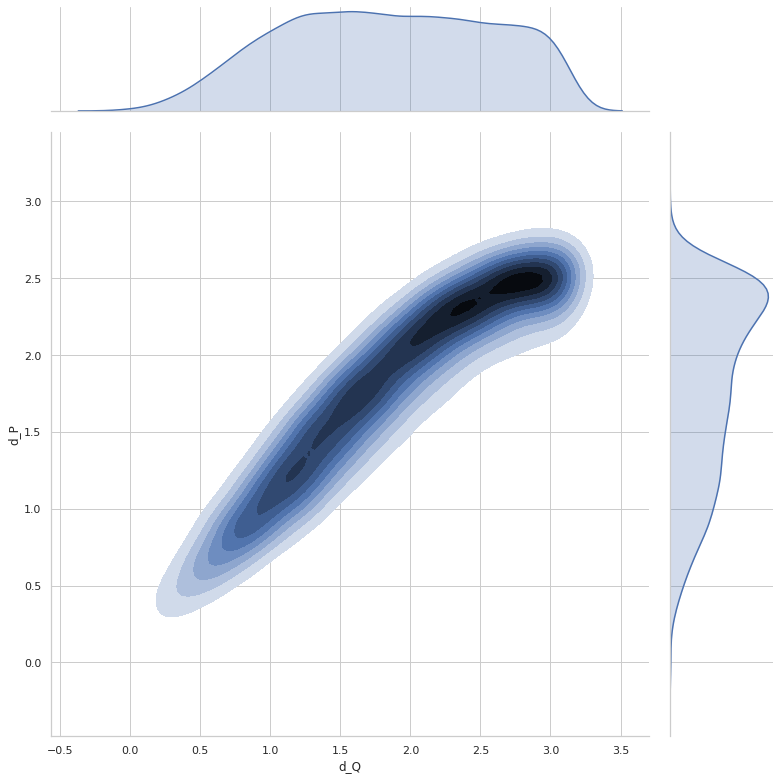

In [34]:
#plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
sns.set(style="white", color_codes=True)
sns.set(style="whitegrid")
JG1 = sns.jointplot(x="d_Q", y="d_P", data=df1, kind="kde", color="g", height=11,joint_kws=dict(shade_lowest=False));  # "reg", "kde"
JG2 = sns.jointplot(x="d_Q", y="d_P", data=df2, kind="kde", color="b", height=11,joint_kws=dict(shade_lowest=False, scatter_kws=dict(alpha=0.5)));  # "reg", "kde"

# #subplots migration
# f = plt.figure()
# for J in [JG1, JG2]:
#     for A in J.fig.axes:
#         f._axstack.add(f._make_key(A), A)
        
# #subplots size adjustment
# f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
# f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
# f.axes[3].set_position([0.05, 0.05, 0.4,  0.4])
# f.axes[4].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[5].set_position([0.45, 0.05, 0.05, 0.4])

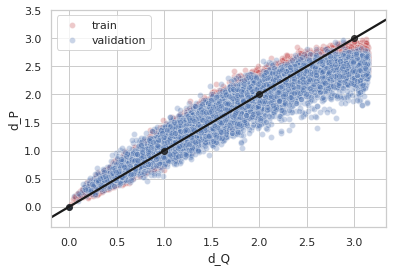

In [35]:
plt.clf()
sns.set_context({"figure.figsize": (11,8)})
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="r", alpha=0.3, label="train")  # "reg", "kde"
sns.scatterplot(x="d_Q", y="d_P", data=df2, color="b", alpha=0.3, label="validation");  # "reg", "kde"
x = np.arange(0, np.pi)
sns.regplot(x=x, y=x, color="k")

In [37]:
from scipy.stats import linregress

lr = linregress(df1.d_Q, df1.d_P)
print(f"Train d_P/d_Q = {lr.slope}, intercept = {lr.intercept}")

lr = linregress(df2.d_Q, df2.d_P)
print(f"Validation d_P/d_Q = {lr.slope}, intercept = {lr.intercept}")

Train d_P/d_Q = 0.8353791783391286, intercept = 0.29369663977879235
Validation d_P/d_Q = 0.7635819002080287, intercept = 0.3746792506539234


In [30]:
slope, intercept = 1, 0

---

# 2. Angle Recovery

In [31]:
num_pairs = 10000

###### Predicted Angles (initialization)

In [32]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(NUM_PROJECTIONS, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0003, 6.2827)


(5000,)

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [33]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [34]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

In [35]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=num_pairs, style="random", k=k)
        
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [y[i] for i in idx1]
        a2_true = [y[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [36]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

## Optimization loop (projection-true & angles-predict)

##### True Angles

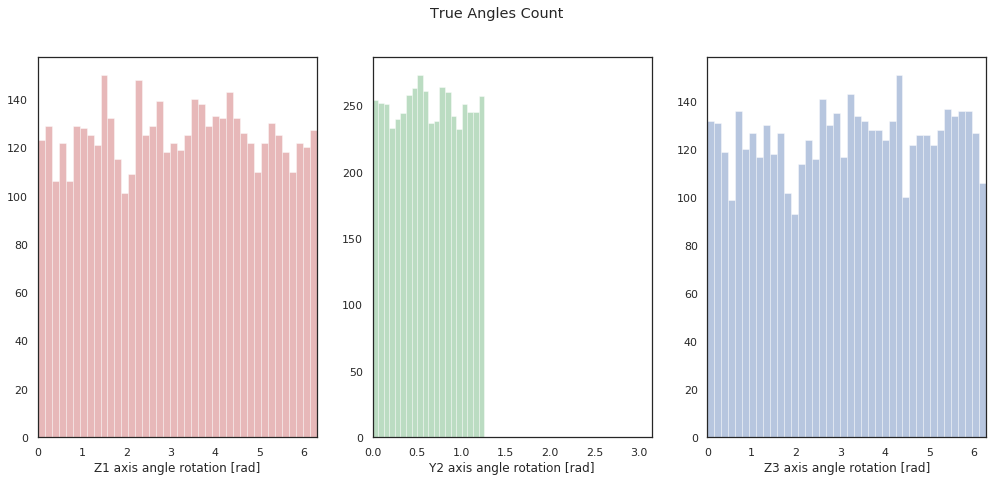

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(y[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(y[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(y[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Predicted Angles [INITIAL]

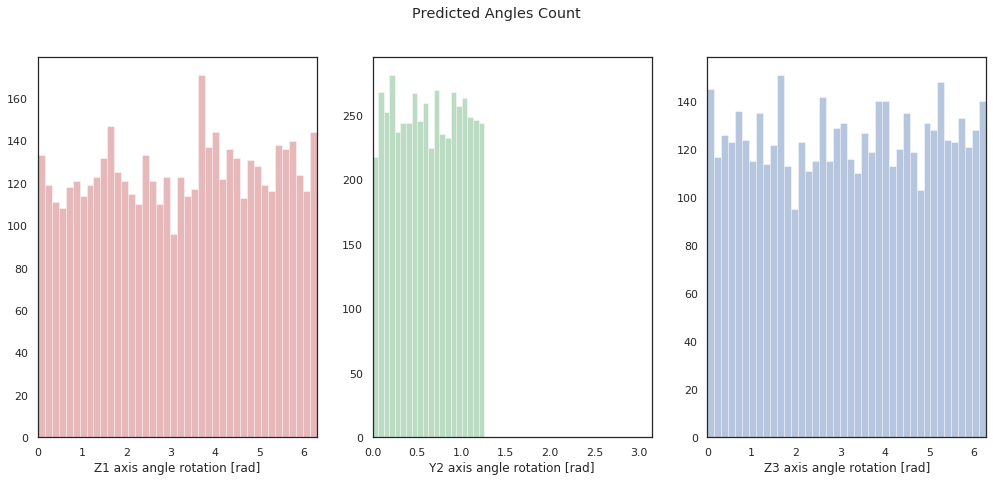

In [38]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [39]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

step 50/500 (106s): loss = 1.11e+00
step 100/500 (213s): loss = 1.09e+00
step 150/500 (318s): loss = 1.09e+00
step 200/500 (424s): loss = 1.10e+00
step 250/500 (530s): loss = 1.09e+00
step 300/500 (636s): loss = 1.07e+00
step 350/500 (741s): loss = 1.08e+00
step 400/500 (848s): loss = 1.07e+00
step 450/500 (953s): loss = 1.08e+00
step 500/500 (1059s): loss = 1.09e+00
Mean loss: 1.0868809889772884


step 300/3000 (4679s): loss = 8.54e-01
step 600/3000 (9355s): loss = 8.34e-01
step 900/3000 (14068s): loss = 8.35e-01
step 1200/3000 (18792s): loss = 8.20e-01
step 1500/3000 (23524s): loss = 8.31e-01
step 1800/3000 (28215s): loss = 8.39e-01
step 2100/3000 (32903s): loss = 8.33e-01
step 2400/3000 (37595s): loss = 8.24e-01
step 2700/3000 (42290s): loss = 8.31e-01
step 3000/3000 (46985s): loss = 8.28e-01


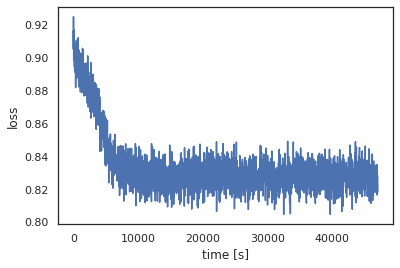

In [40]:
steps=3000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.001)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=num_pairs, style="random", k=k)
    
    # Compute distances between projections
    p1 = [X[i] for i in idx1]
    p2 = [X[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dQspace")
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [41]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

step 50/500 (108s): loss = 9.92e-01
step 100/500 (215s): loss = 9.93e-01
step 150/500 (323s): loss = 1.01e+00
step 200/500 (430s): loss = 9.85e-01
step 250/500 (536s): loss = 1.02e+00
step 300/500 (643s): loss = 1.00e+00
step 350/500 (749s): loss = 1.01e+00
step 400/500 (855s): loss = 9.96e-01
step 450/500 (961s): loss = 9.98e-01
step 500/500 (1068s): loss = 1.01e+00
Mean loss: 1.0030847823131235


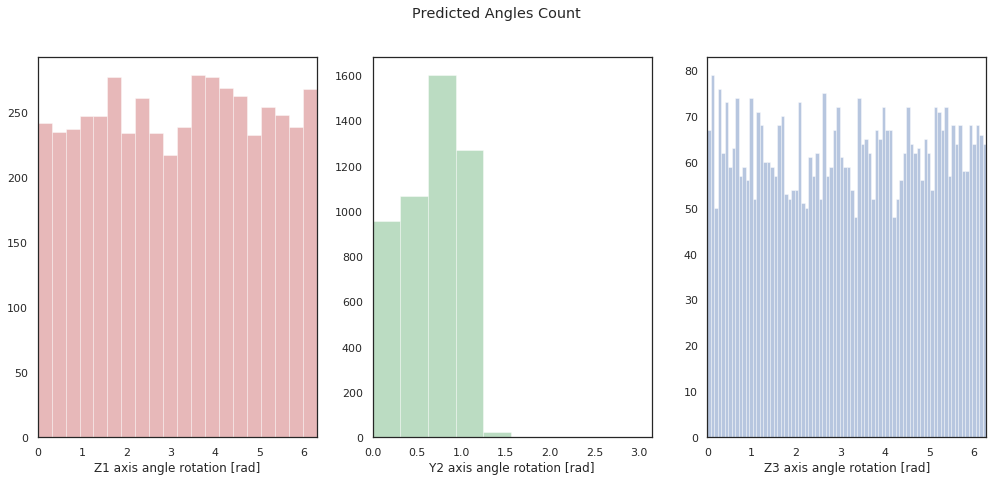

In [42]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [43]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()